# Group 061 Final Project : Traffic Collisions in San Diego

# Introduction

*(Overview here, this is the general summary of what we did)*

## Background

Professor Voytek, in the first lecture of this class, talked about how Uber used spatiotemporal dynamics to differentiate party versus business neighborhoods on the basis of the peaks of Uber demand during the weekdays and weekends and the timing of such peaks. Similarly, we wanted to analyze spatiotemporal data to see which interactions of the time of year, time of day, and location are the most dangerous to drive through based on the number and density of collisions that take place.
    
#### Datasets Used:
- Collisions: https://data.sandiego.gov/datasets/police-collisions/
- Potholes: https://data.sandiego.gov/datasets/gid-pothole/
- Streetlights: https://data.sandiego.gov/datasets/streetlight_inventory/
- Police Presense: https://data.sandiego.gov/datasets/police-beats/
    
In order to answer our question, we first looked at the data given by https://data.sandiego.gov/datasets/police-collisions/ and group it together based on time of day, time of the year, and location based on the address given. Once we grouped that together we used the information to understand where and when it is the most dangerous to drive in san diego.

## Data Science Questions

What are the most dangerous places and times to drive throughout the year? More specifically, we are curious about which factors in particular can predict the likelihood of accidents occurring. We know there are probably certain factors that predict accident likelihood, listed below in the hypothesis, however we would like to see through our data analysis if there may be other factors that predict accident likelihood.

## Hypothesis

We believe that there are a number of factors that are likely to predict a higher probability of accidents in certain areas. These factors include:
- Time of day - Based on influences such as low visibility and drowsiness, it is likely that accidents are more likely to occur at night.
- Time of year -  During the holidays there tends to be more people on the roads and increased instances of DUI, there is likely to be increased accidents during these times.
- Police presence - People tend to drive slower and more carefully around police cars and more diligent in obeying traffic laws. Therefore accidents, especially those involving traffic violations are less likely to occur in areas of higher police presence.
- Quality of road infrastructure - Indicators of bad road infrastructure and maintenance such as potholes or unclear or deteriorating road indicators and signs are likely to cause either confusion or loss of control while driving, therefore leading to increased instances of traffic collisions.
- Location - there are a number of effects of living or driving in a certain location whether it be the average age of the people in the group, the buildings in the area (day life and nightlife), and possibly the type of people who live in that area (single, married, family, young adults)


# Imports

In [14]:
import pandas as pd # DataFrames, Series
import numpy as np # Math Module
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
import datetime # Datetime 
from dateutil.parser import parse # String Conversion to Datetime
import folium # Folium Map
from folium import plugins # Folium Heatmap
from pygeocoder import Geocoder # Geocoding
import json # Reading JSON files
import re # Regular Expressions
from sklearn.cluster import KMeans # K Means Clustering for Location Data
from scipy.cluster.vq import whiten # Whiten datapoints
import matplotlib
from tqdm import tqdm_notebook as tqdm # Progress Bars
from scipy import stats # Statistical Tests
from IPython.display import display
from shapely.geometry import MultiPolygon
from shapely.geometry import shape
from scipy.interpolate import UnivariateSpline
from osgeo import ogr
from osgeo import osr

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

ModuleNotFoundError: No module named 'osgeo'

# Reading Data

In [15]:
df = pd.read_csv('Datasets/pd_collisions_datasd_v1.csv')

In [16]:
df.head()

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,170082,2017-01-01 00:01:00,935,5500,,VALERIO,TRAIL,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,170101,2017-01-01 00:01:00,322,6400,,CRAWFORD,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
2,170166,2017-01-01 00:01:00,124,8300,,CAM DEL ORO,,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
3,170218,2017-01-01 00:01:00,325,8100,,ROYAL GORGE,DRIVE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
4,170097,2017-01-01 01:00:00,521,1000,,11TH,AVENUE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR


# EDA

#### Dataset Description:

In this project, we are using the car collision dataset from San Diego Government Web Page. We are using their user-related data form 2017 to 2019. We use the data from all months to analysis the collision pattern within all counties of San Diego. 


The reason of why we chose this dataset is that this data set contains information of collisions from the whole San Diego City, which has a large amount of population for our analysis. Also, this dataset is an official dataset, which means that its information is relatively accurate.


The dataset includes 16 different features in a total of 28595 data entries.


*report_id* : The unique ID of the report of each accident.

*data_time* : The date and time of the accident.

*police_beat* : The territory and time that a police officer patrols.

*address_number_primary* : The primary address number.

*address_pd_primary* : The primary address direction (W/S/N/E).

*address_road_primary* : The primary road name.

*address_sfx_primary* & *address_pd_intersecting* & *address_name_intersecting* & *address_sfx_intersecting* : Other address information.

*violation_section* : California Vehicle Code Violations.

https://www.dmv.ca.gov/portal/dmv/?1dmy&urile=wcm:path:/dmv_content_en/dmv/dl/vioptct

*violation_type* : The Type of Violation (VC/PC/MC/ZZ/CO/HS)

*charge_desc* : The charge description, which descripts each charge. Based on the research, the description is based on the violation section.

*injured* : Number of injuries( Max: 180, Min: 0, Mean: 0.59 )

*killed* : Number of Death( Max: 3, Min: 0, Mean: 0.00465 )

*hit_run_lvl*: Level of severity if the collsion is a hit-run. (MISDEMEANOR/FELONY)


First, check the missingness of the dataset:

In [17]:
df.isnull().sum()/28595

report_id                    0.000000
date_time                    0.000000
police_beat                  0.000000
address_number_primary       0.000000
address_pd_primary           0.000000
address_road_primary         0.000000
address_sfx_primary          0.000140
address_pd_intersecting      0.000000
address_name_intersecting    0.000000
address_sfx_intersecting     0.000350
violation_section            0.000000
violation_type               0.000000
charge_desc                  0.000000
injured                      0.000000
killed                       0.000000
hit_run_lvl                  0.533905
dtype: float64

We noticed that there is a significant amount of missing values in hit_run_lvl, which is around 53.3905% of the total entries. Hence, we print out unique values of hit_run_lvl:

In [18]:
df.hit_run_lvl.unique()

array(['MISDEMEANOR', nan, 'FELONY'], dtype=object)

There are only three unique values, and two of them represent levels of severity of hit-run collisions, and the other one represents it is not a hit-run. Hence, its missing type is missing by design (MD). We should not impute it since it is designed to miss.

# Factor 1 - Location

## Data Cleaning

The collisions dataset was already clean for the most part, with little to no improperly formated entries or incomplete data points. We did however extract and reformat parts of this dataset to make it easier to analyse.   

For other datasets we used, such as pothole repair requests, contain time data from before 2017. The earliest point in the collisions dataset is from 1/1/17, so for the sake of keeping our data analysis consitent with answering the question of which factors are likely to predict accidents, we drop any points from these datasets with dates before 2017 as it would be unreasonable to associate this data with collisions that have happened between the beginning of 2017 to now.

## Extraction of Locations from Dataset

In [19]:
addresses = df.apply(lambda x : ' '.join(
    str(i).strip() for i in [x.address_number_primary, x.address_pd_primary, x.address_road_primary, x.address_sfx_primary] 
) + ', SAN DIEGO', axis = 1)

In [20]:
addresses.shape

(28595,)

## Geocoding

Since API calls take a lot of time, we would not want to make 28595 API calls every time we ran this notebook, so we delegated this task to an external file called `GeoEncoding.py` and saved all the data to `Datasets/locations.csv` so that this data is easily accessible.

In [21]:
locations = pd.read_csv('Datasets/locations.csv')['Coordinates'][:1000] # Not processing all points right now for time

# Cleaning invalid points
locations = locations[locations != '(-1, -1)']

In [22]:
LAT, LON = 0, 1 

def extract_latitude(x):
    return float(x[x.find('(') + 1 : x.find(',')])
def extract_longitude(x):
    return float(x[x.find(',') + 1 : x.find(')')])

center = np.mean(locations.apply(extract_latitude)), np.mean(locations.apply(extract_longitude))

center

(32.7809571256, -117.1437266858)

While geocoding the addresses from the collisions dataset, the API returned several instances of no results being found for certain addresses that either didn't exist or didn't contain a house or building number. These points accounted for less than 2% of the data we had, so we decided to drop these points from the data used to generate the folium maps.

## Map

In [23]:
# Creating map
m = folium.Map(center, zoom_start = 11)

### Marking each point on map

In [24]:
for location in tqdm(locations):
    lat = float(location[location.find('(') + 1 : location.find(',') ])
    lon = float(location[location.find(',') + 1 : location.find(')') ])
    folium.CircleMarker([lat, lon],
                        radius = 2,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)
m

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


We can see that there are certain areas that have more crashes than the others, for example, Downtown.

The next step would be to find out if this increase in crashes is significant. We can infer this from clustering our data points.

In [25]:
lats = locations.apply(extract_latitude)
lons = locations.apply(extract_longitude)

coords = np.array([lats, lons]).T
km = KMeans(n_clusters = 10, random_state = 0).fit(coords)

In [26]:
kmap = folium.Map(center, zoom_start = 11)

color_set = ['red', 'yellow', 'orange', 'green', 'blue', 'violet', 'pink', 'purple', 'black', 'grey']

for i in tqdm(range(len(locations))):
    folium.CircleMarker(
        (lats[i], lons[i]),
        radius = 10,
        color = color_set[km.labels_[i]]
    ).add_to(kmap)
kmap

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


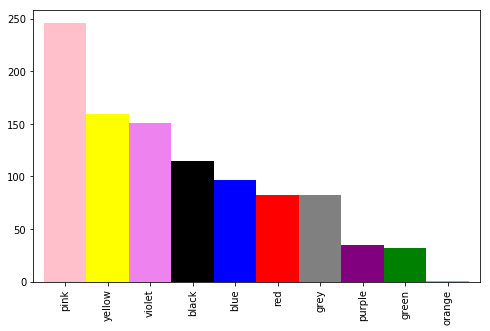

In [27]:
dist = pd.Series(km.labels_).apply(lambda x : color_set[x]).value_counts()
dist.plot(kind = 'bar', figsize = (8, 5), color = dist.index, width = 1)

It seems like the data does produce particular significantly different sized clusters at different reigons in the data. Thus, we can conclude that **Location is a significant factor in determining car crashes**.

# Factor 2  - Time of Year

## Extraction of Date from Dataset

*I was thinking for this chart we label the bottom axis by date or month/year something like that
Also I'd like to have a graph maybe like this one that shows average crashes per day on a given date maybe
then it would look a little more clean and be easier to show how crash frequency fluctuates throughout the year*

In [28]:
dates = pd.DataFrame(df['date_time'].apply(lambda s : map(int, parse(re.search(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', s).group()).strftime('%m %d %W').split())).to_dict()).T.rename({
    0 : 'day',
    1 : 'month',
    2 : 'week_number',
}, axis = 1)

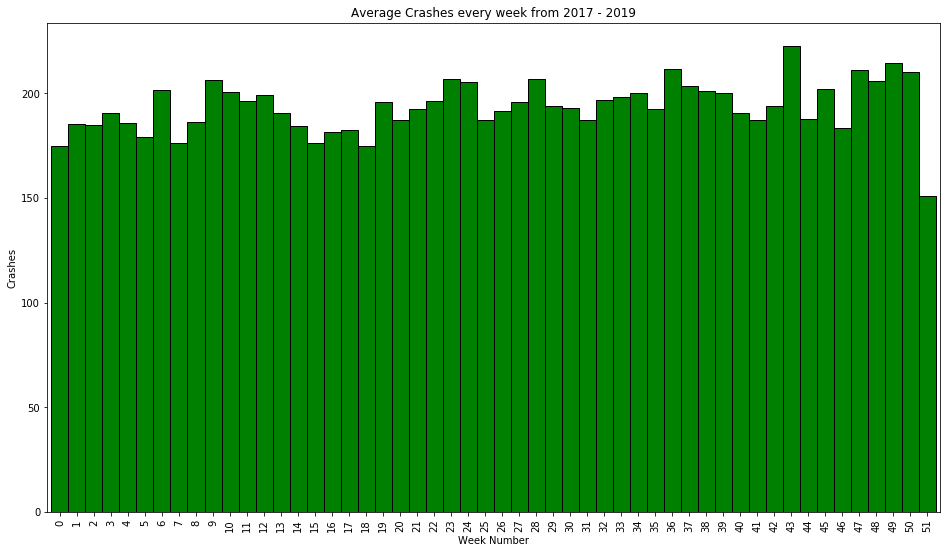

In [29]:
def dates_summary(d):
    d = d.copy()
    grouped = d.groupby('week_number').count()
    grouped.drop([0, 53], inplace = True)
    l = []
    
    for group in grouped.iterrows():
        if group[0] < 44:
            l.append(group[1]['day'] / 3)
        else:
            l.append(group[1]['day'] / 2)
    
    pd.Series(l).plot(kind = 'bar', color = 'green', edgecolor = 'black', figsize = (16,9), width = 1)
    plt.title('Average Crashes every week from 2017 - 2019')
    plt.ylabel('Crashes')
    plt.xlabel('Week Number')
    
    return pd.Series(l)
    
averages = dates_summary(dates)

## Hypothesis Testing

Now that we have the average crashes for our data, we need to check if date is a significant factor. We can use `scipy.stats.kstest` to confirm.

Our hypotheses will be :
$$
H_0 = \text{Our distribution is uniform} \\ 
H_a = \text{Our distribution is not uniform}
$$

We shall assume $\alpha = 0.05$

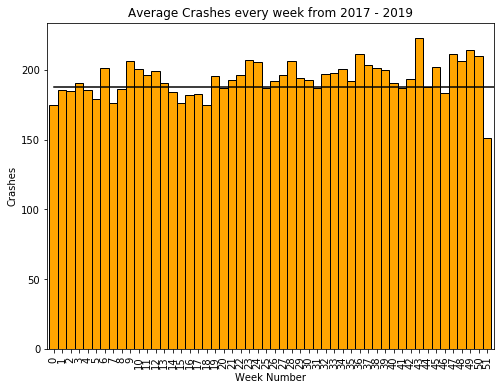

In [30]:
# Plotting against a uniform dist

x = np.linspace(stats.uniform.ppf(0), stats.uniform.ppf(1), 1000)
averages.plot(kind='bar', color = 'orange', width = 1, edgecolor = 'black', figsize = (8, 6))
plt.plot(x * 53, stats.uniform.pdf(x) * 187.61728395061726, color = 'black')
plt.title('Average Crashes every week from 2017 - 2019')
plt.ylabel('Crashes')
plt.xlabel('Week Number')  
pass

In [31]:
ks_stat, p_value = stats.kstest(averages, 'uniform')
print(f'P-Value : {p_value}')

P-Value : 0.0


Since our p value is less than our $\alpha = 0.05$, we can reject $H_0$ in favor of $H_a$. Therefore, we can conclude __Time of Year is a significant determinant of Car Crashes__.

# Factor 3 - The Time of Day

## Crashes Per Minute

FIrst, we will group the dataframe by hours and minutes to see if there are any significantly high or low counts during any specific time periods.

In [32]:
# convert the "data_time" column to data-time object
times = pd.to_datetime(df.date_time)
df_td = df.copy()
df_td.date_time = times

Text(0, 0.5, 'Number of Crashes')

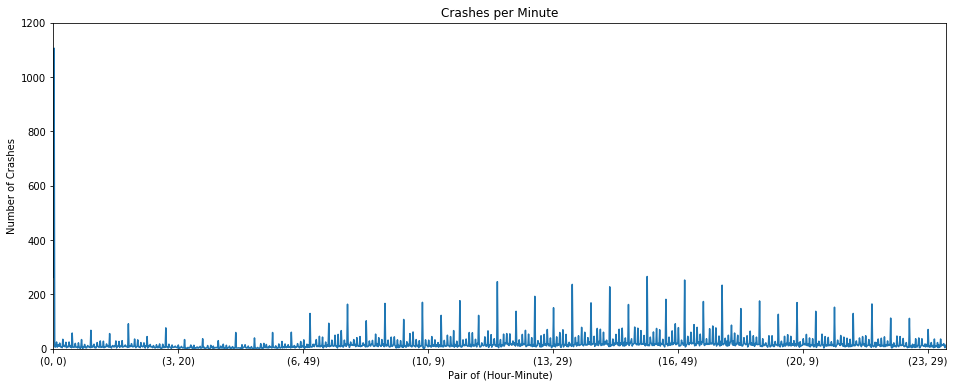

In [33]:
# group the dataframe by hour and minutes in data_time column
grp = df_td.groupby(by=[df_td.date_time.map(lambda x : (x.hour,x.minute))])
# get counts
df_grp_minute = grp.count()
df_grp_minute = df_grp_minute[df_grp_minute.columns[:1]]

# graph the dataframe to visualize the number of crashed per minute
df_grp_minute.report_id.plot(kind='line', figsize=(16,6)).set_ylim(0,1200)
plt.title('Crashes per Minute')
plt.xlabel('Pair of (Hour-Minute)')
plt.ylabel('Number of Crashes')

We noticed a significantly high amount of car crashed happening around 1 AM, with a value of 1106. The information does not make sense since it has a huge gap comparing to other time periods. 

We decide to mark it as an outliers. One potential reason is that Midnight is the default time. While one accident does not a time label, then its data-time will be set to that day's midnight. Hence, we decide to drop the 12:00 AM and 12:01 AM Entries.

Text(0, 0.5, 'Number of Crashes')

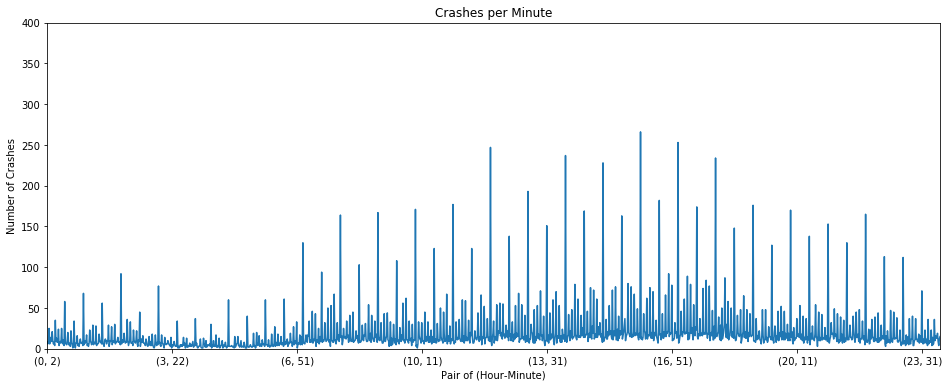

In [34]:
# drop entries around midnight
df_grp_minute_drop = df_grp_minute.drop(df_grp_minute.index[[0,1]])

# graph the dataframe to visualize the number of crashed per minute
df_grp_minute_drop.report_id.plot(kind='line', figsize=(16,6)).set_ylim(0,400)
plt.title('Crashes per Minute')
plt.xlabel('Pair of (Hour-Minute)')
plt.ylabel('Number of Crashes')

When we look at the dataset, we noticed that there are many extreme values in each hour. One potential reason is that during many circumstances, police did not record the very specific time of the accident. Hence, they will only record hour in the file without minutes. This is why the the crashed at the beginning of each hour is very high. 

Based on this, we believe group by minutes and hours is not the best approach. We decide to group by hours and see the crashed per hour in a day.

## Crashes Per Hour

After, we group the dataframe by ONLY hours to visualize the amount of car crushed in different time periods in a day.

In [35]:
# define a method to drop all entries around midnight first
def drop_midnight(row):
    if '00:00:00' in row.date_time or '00:01:00' in row.date_time:
        return True
    return False

# apply method on the dataframe to drop these entries
l = df.apply(drop_midnight,axis = 1)
df_after_drop = df_td.drop(df_td[l].index)

# convert the "data_time" column to data-time object
times_minute = pd.to_datetime(df_after_drop.date_time)
df_after_drop.date_time = times_minute

In [36]:
df_after_drop.head()

,report_id,date_time,police_beat,address_number_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
4,170097,2017-01-01 01:00:00,521,1000,,11TH,AVENUE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
5,170220,2017-01-01 01:00:00,524,1000,,A,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
6,170153,2017-01-01 01:18:00,437,2600,,RAMFOS,PLACE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,NaN
7,170035,2017-01-01 01:53:00,935,3900,,DE LA VALLE,,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
8,170044,2017-01-01 01:58:00,115,9100,,SYDNEY,COURT,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR


Text(0, 0.5, 'Number of Crashes')

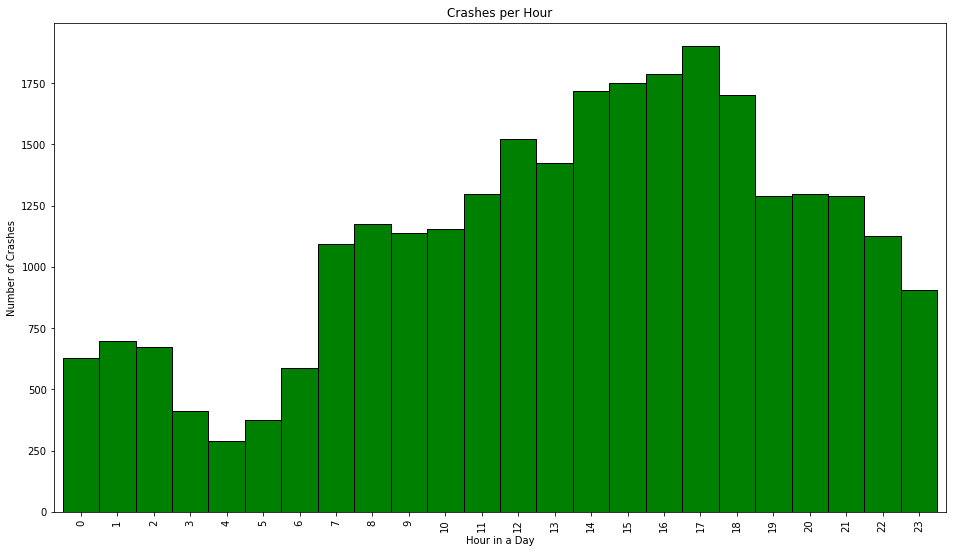

In [37]:
# group the dataframe by hours in data_time column
grp = df_after_drop.groupby(by=[df_after_drop.date_time.map(lambda x : (x.hour))])
# get counts
df_grp = grp.count()
df_grp = df_grp[df_grp.columns[:1]]

# graph the dataframe to visualize the number of crashed per 
df_grp.report_id.plot(kind = 'bar', color = 'green', edgecolor = 'black', figsize = (16,9), width = 1)
ticks = plt.xticks(np.arange(0, 24, 1.0))
plt.title('Crashes per Hour')
plt.xlabel('Hour in a Day')
plt.ylabel('Number of Crashes')

Based on the result of our visualization, we noticed that the number of crashes is very high in the afternoon and reaches maximum around 5 PM. Potential reason of this is the afternoon is traffic peak-hour, that people will drive home from work. After 5 PM, the number of crashed will decrease as the time pass and reach its minimum around 4 AM in the morning, that it is resonable since not many people drive during the early morning.

## Hypothesis Testing

Now that we have the average crashes for each hour in a day, we need to check if different hour in one day is a significant factor to teh number of crashed. We can use `scipy.stats.kstest` to confirm.

Our hypotheses will be :
$$
H_0 = \text{Our distribution is uniform} \\ 
H_a = \text{Our distribution is not uniform}
$$

We shall assume $\alpha = 0.05$

In [38]:
# Average Crashed
df_after_drop.shape[0]/24

1134.625

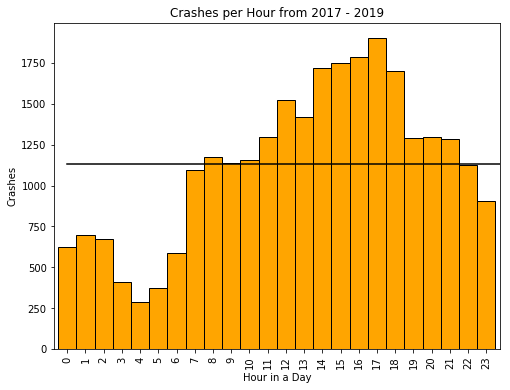

In [39]:
# Plotting against a uniform dist
x = np.linspace(stats.uniform.ppf(0), stats.uniform.ppf(1), 1000)
df_grp.report_id.plot(kind='bar', color = 'orange', width = 1, edgecolor = 'black', figsize = (8, 6))
plt.plot(x * 24, stats.uniform.pdf(x) * 1134.625, color = 'black')
plt.title('Crashes per Hour from 2017 - 2019')
plt.ylabel('Crashes')
plt.xlabel('Hour in a Day')  
pass

In [40]:
ks_stat, p_value = stats.kstest(df_grp.report_id, 'uniform')
print(f'P-Value : {p_value}')

P-Value : 0.0


Since our p value is less than our $\alpha = 0.05$, we can reject $H_0$ in favor of $H_a$. Therefore, we can conclude __Time of Day is a significant determinant of Car Crashes__.

# Factor : Road Infrastructure

For road infrastructure we look at data we have on two different variables, pothole and streetlight locations. Potholes are generally a good predictor of the quality of road infrastructure, wherever there are a lot of potholes, there tends to be less investment in upkeep of road quality and deteriorating infrastructure. We also look at location of streetlamps because its easy to visualize and more streetlights should provide better visibility, which is often a key factor in the cause of many accidents, especially during the night. 

## Potholes

The first of our aspects that we looked into when discussing the aspects of road infrastructure and its possible affects on car crashes was potholes. We found a potholes dataset for California, read it, and then cleaned it. We cleaned the code by taking only pothole requests from 2017 to 2019 as that was the only time relevant to our crashes data. Below is our code of reading and cleaning the pothole. 

In [ ]:
# Reading Potholes Data
df_p = pd.read_csv('Datasets/Potholes/get_it_done_pothole_requests_datasd_v1.csv')

# filtering out only the relevant pothole requests (from the time of crashes in our data)
df_p = df_p[df_p['date_requested'].str.contains('2017') | 
            df_p['date_requested'].str.contains('2018') |
            df_p['date_requested'].str.contains('2019')]

df_p = df_p.reset_index()

In [ ]:
# finding the center of the map for the potholes
LAT, LON = 0, 1 
center = np.mean(df_p['lat']), np.mean(df_p['lng'])

center

In [ ]:
# Creating map for potholes
m2 = folium.Map(center, zoom_start = 11)
m3 = folium.Map(center, zoom_start = 11)

In [ ]:
for i in tqdm(range(20000)):
    try:
        lat = float(df_p['lat'][i])
        lon = float(df_p['lng'][i])
        folium.CircleMarker([lat, lon],
                            radius = 1,
                            fill_color="#3db7e4", # divvy color
                            ).add_to(m2)
    except:
        pass

m2.save('Images/pothole_map.html')
display(m2)

Above is the map of the potholes in the area, as we can see it is hard to see where potholes were more significant. Because of this we created a heat map below to more easily compare to the locations map of crashes.

In [ ]:
# making the heatmap for potholes
m3.add_child(plugins.HeatMap(df_p[['lat', 'lng']][:3000].values, radius = 20))
m3.save('Images/pothole_heatmap.html')
display(m3)
display(m) # replace with heat map when made 

## We need to have the pothole heatmap and locations heat map above side by side *******

Looking at the two heat maps, we can see the similarities between the importance of the location of potholes crashes in 
relation to crashes. We see this through the red spots in the heatmap. Just as the crashes were more prominant in places around
downtown San Diego, the potholes show high pothole request activity there as well. While this is just one factor, we believe
it does contribute to the overall affects of crashes in San Diego.

## Street Lights

In addition to looking at the pothole requests distribution throughout San Diego, we also looked at the street light distribution on roads in San Diego to see if the lack of street lights may or may not have an affect on the crashes in San Diego. We found a street lights for California, read it, and then checked to see if we needed cleaning. We first checked for invalid latitudinal and longitutinal values in our data. After finding that all of the values were okay, we realised we could read the data as is for accurate results.

In [ ]:
df_lights = pd.read_csv('Datasets/Streetlights/streetlight_locations_datasd_v1.csv')

In [ ]:
# finding the center of the map for the street lights
LAT, LON = 0, 1 
center = np.mean(df_lights['lat']), np.mean(df_lights['lng'])

center

In [ ]:
# Creating map for streetlights
m4 = folium.Map(center, zoom_start = 11)
m5 = folium.Map(center, zoom_start = 11)

In [ ]:
for i in tqdm(range(20000)):
    try:
        lat = float(df_lights['lat'][i])
        lon = float(df_lights['lng'][i])
        folium.CircleMarker([lat, lon],
                            radius = 1,
                            fill_color="#3db7e4", # divvy color
                            ).add_to(m4)
    except:
        pass

m4.save('Images/streetlights_map.html')
display(m4)

Similar to the potholes map, it is hard to specifically tell where there are more or less street lights throughout San Diego,
so once again we turned the street lights data into a heat map for easier comparison.

In [ ]:
# making the heatmap for the street lights
m5.add_child(plugins.HeatMap(df_lights[['lat', 'lng']][:5000].values, radius = 20))
m5.save('Images/streetlights_heatmap.html')
display(m5)
display(m) # replace with heat map when made 

## We need to have the streetlights heatmap and locations heat map above side by side *******

When focusing on specific points in the heatmape such as downtown San Diego, we see that there are certain places that are colder showing a lack of street lights in the area. Focusing on downtown, as that is a crash hotspot, we see that there may be some sort of corolation between a lack of street lights and the amount of car crashes. 

# Police Beat

We acquired a police beat dataset from the San Diego police department which displays the areas of police beats across the San Diego county.

We first go through our dataframe and get the number of crashes for each beat and get the top ten results into a dataframe. We then plot this into a bar graph to see the beats with the most number of crashes.

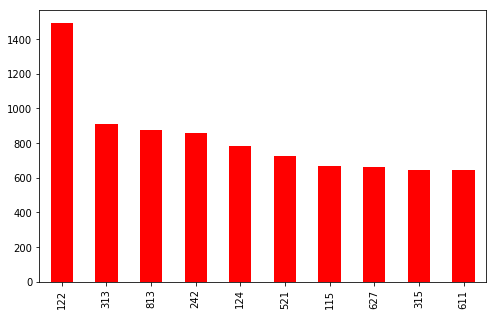

In [67]:
count = df['police_beat'].value_counts()
count = count.head(10)
count.to_frame()
count_plot = count.plot(kind = 'bar', figsize = (8, 5), color = "#ff0000")
#count_obj = pd.DataFrame(columns=['beat', 'color']).set_index('beat', drop=False)


We then load the police dataset that divides the county into police beets. We also initialize a dictionary of all the police beats to all be blue. We then go through every beat in the top ten count from above and change their color to be blue in the dictionary. Luckily the police beat polygon dataset did not need to be cleaned and came in a geojson format.

In [68]:
#Variables to hold the file location/name
police_geo = 'Datasets/Police Beats/pd_beats_datasd.geojson'

#Load jsons 
popo = json.load(open(police_geo))
dict_color = dict.fromkeys(df['police_beat'], "#ff0000")

for i in range(0, df['police_beat'].max()):
    dict_color[i] = 'blue'
    
for i in range(0, 10):
    dict_color[count.index.tolist()[i]] = 'red'

We then add this geographical area to the map defined earlier with the crashes and color each region based on our dictionary

In [69]:
#Open these geojson files
folium.GeoJson(
    police_geo,
    style_function=lambda x: {
        'color' : dict_color[x['properties']['beat']],
    },
    name='geojson'
).add_to(m)


folium.LayerControl().add_to(m)

m.save("./mymap.html")


We then calculate the area of each police beat and set it in the keys of a dictionary. We then loop through the original database and match the police beets with number of crashes to get the corresponding number of crashes for each police beat area.

In [70]:
source = osr.SpatialReference()
source.ImportFromEPSG(4326)

target = osr.SpatialReference()
target.ImportFromEPSG(5243)

transform = osr.CoordinateTransformation(source, target)

area_dict = {}
count = df['police_beat'].value_counts().to_dict()

for i in range(0, len(popo['features'])):
    poly = ogr.CreateGeometryFromJson(str(popo['features'][i]['geometry']))
    poly.Transform(transform)
    if popo['features'][i]['properties']['beat'] in count:
        area_dict[poly.GetArea()] = count[popo['features'][i]['properties']['beat']]
    

We then plot the graph with number of collisions on the x axis and area of the police beats on the yaxis. This will help us understand the relationship between police beat area and crashes. We also drew a line of best fit to show the trend.

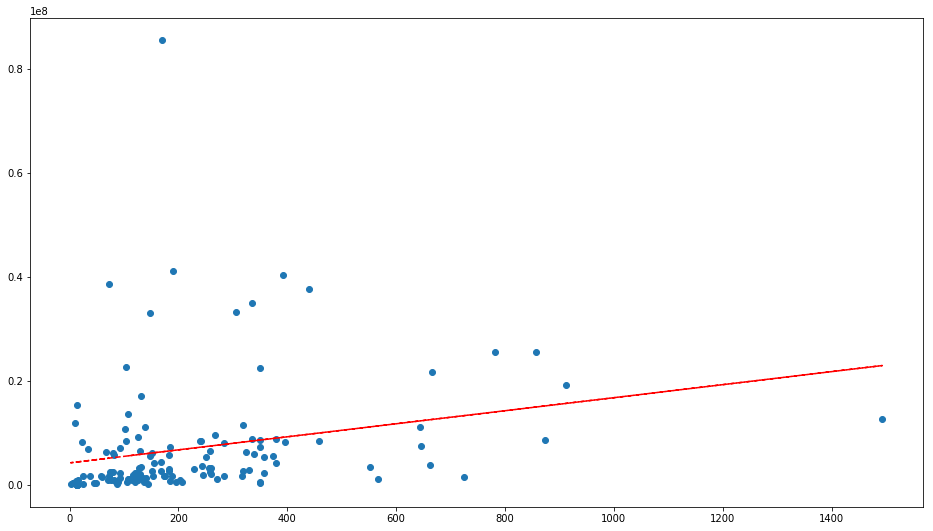

In [71]:

areas = list(area_dict.keys())           
collisions = list(area_dict.values())  

plt.scatter(collisions, areas)

line = np.polyfit(collisions, areas, 1)
p = np.poly1d(line)
x = plt.plot(collisions,p(collisions),"r--")

plt.show()

Initially we saw lots of clumps around the smaller police beats and assumed the smaller police beats meant more concentrated crashes. However we find that the bigger the police beat, the more crashes even though there are less patrols. 

# Discussion

### Factor 1 - Location

From our clustering analysis of the locations data we concluded that location is a significant factor in predicting accident frequency, with the largest number of accidents occuring within the small cluster in the central downtown area, and decreasing the further the clusters are away from the larger metropolitan area.

### Factor 2 - Time of Year

For time of year we were unable to reach a definite conclusion on. Our statistical test shows that there should be a relation between date of year and average number of collisions for a specific week. However, we were unable to determine why that was the case. Perhaps it a simply a statistical anamoly since the data we have on collisions only goes back 3 years, so its hard to say definitively wether time of year actually is a likely predictor of collisions. 

On the other hard, we did look at specific days during the year, notably holidays, and saw that on many holidays there tends to be a larger influx in collision occurances. However, this isn't always consistent for every US holiday. 

### Factor 3 - Time of Day

For time of day we can definitively say that it is a likely predictor for accidents. We first visualized number of crashed per minute in a day. Then, we realized that there's a unreasonable large amount of crashes at midnight. We see those crashed as outliers and dropped them. However, even after the drop our visualization does not give us a clear view of the trend, because many police officers only record the hour of the accident not including the minutes. Hence, many accidents took place at the first minute of each hour in record. We decide to further visualize number of crashed per hour in a day. 

Based on our new graph, we could clearly see that collision frequency tends to increase steeply at the beggining of the day, and is generally at its highest between the hours of 4pm and 6pm. This is most likely due to sheer traffic volumes during these times. With it being rush hour and the highest number of cars on the road during this time, it's much more likely a collision will occur during commute hours. Based on our hypothesis testing, we obtained a p-value of 0, which is smaller than 0.05. Hence, we conclude that time of day is a significant factor.

### Factor 4 - Road Infrastructure

*(Discussion Here)*

### Factor 5 - Police Presense

*(Discussion Here)*

# Conclusion

To answer our original question, we came to the conclusion that location, time of day and quality of road infrastructure are the best predictors of collision likelyhood from the data we analysed. Specifically, the most dangerous time and place to drive would be in the central downtown area, during peak rush hour around 5pm, and where the road infrastructure is the worst. 

Of course, given the difference in traffic volumes across the city, a varaible in which we couldn't figure out how to best represent or compare with our other factors, one's individual likelyhood of getting into an accident at any specific time or place, we cannot definitively predict. However, if you were to take a guess at this moment when and were the next collision is going to take place in San Diego, our analysis can provide some level of insight into when, where, and whichever other factors cooncide and predict collision likelyhood.

In conclusion, be safe while driving, always follow the rules of the road and be aware of your surroundings while driving. Be prepared just incase you may get into an accident, or may come across one. But most importantly, be aware and have knowledge about the places you're driving to and through, its infrastructure and local driving laws, the time of day and weather, and how each of these factors may affect your navigation. This kind of knowledge can be the difference between getting from point A to B, or getting into an accident on the way. 